In [1]:
import pandas as pd
import glob
import csv
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta, time

In [ ]:
def group_by_age(age):
        if age <13:
            i='0-12'
        elif age <18:
            i='13-17'
        else:
            i='18+'
        return i

In [ ]:
def str_to_time(value):
    if isinstance(value, str):
        minut =value.split(':')[0]
        sec_milisec =value.split(':')[1].split('.')
        return timedelta(minutes=int(minut), seconds=int(sec_milisec[0]), milliseconds=int(sec_milisec[1]))
    else:
        return timedelta(minutes=0, seconds=0, milliseconds=0)

In [ ]:
path =r'C:/Users/woj/test_merge/compdata/' # use your path
all_files = glob.glob(os.path.join(path, "*.csv"))
df_from_each_file =pd.concat((pd.read_csv(f, encoding='iso8859_10') for f in all_files), ignore_index=True)


In [ ]:
df= df_from_each_file.drop(df_from_each_file.columns[0], axis=1)

My dataset include also starts swedish swimmers abroad what are not interesting me now.
I am going to find unique places of competition and compere with cities in Sweden. I had a problem to find list of pools so ive decided to use the list of urban areas from wikipedia.



In [ ]:
# comp is going to include unique places of competition
comp=pd.Series(df.place.unique())
# list urban areas from wikipedia and preparing date to comparison
url = 'https://en.wikipedia.org/wiki/List_of_urban_areas_in_Sweden'
wiki_df = pd.read_html(url, header=0)
wiki_df= wiki_df[0].drop(wiki_df[0].columns[1:6], axis=1)
cities=pd.np.array(wiki_df[wiki_df.columns[0]])

comp_cities = comp[comp.isin(cities)]
# sw_df include only competition in sweden


Some preprocesing: creating column with age of swimmer during competition, translate column names to english,
removing useless date from earlier than 2000.

In [ ]:
sw_df = df[df.place.isin(comp_cities)]
eng_col = ['name', 'born', 'club', 'gren', 'time', 'finaPoints','competition name', 'place',
           'date', 'organizer', 'pool size']
sw_df.columns = eng_col # change columns names to english
sw_df= sw_df.dropna(axis=0) # remove uncompleted rows
sw_df = sw_df.drop('organizer', axis=1)
sw_df['year'] = np.int_(sw_df.loc[:,'date'].apply(lambda x: x.split('-')[0])) # for future column with year will be usefull
sw_df['age'] = sw_df.loc[:,'year'] - np.int_(sw_df.loc[:,'born']) # kids age
sw_df['time_edit'] = sw_df['time'].apply(lambda x: str_to_time(x)) # convert time from str to timedelta with same format
sw_df =sw_df[(sw_df['year']>2005) &(sw_df['year']<2017)] # im going to use only years where data is complete
sw_df['group_age']=sw_df['age'].apply(group_by_age) # spliting swimmers into age groups (0-12, 13-17, 18+)
sw_df['club']=sw_df['club'].astype('category')
sw_df['gren']=sw_df['gren'].astype('category')
sw_df['place']=sw_df['place'].astype('category')
sw_df['group_age']=sw_df['group_age'].astype('category')
# for ploting histograms showing time in milliseconds
sw_df['milisec_time']= sw_df['time_edit'].apply(lambda x: x.seconds*100+x.microseconds /1000)
sw_df['men']=True
sw_df.to_csv('sw_d_men.csv')

# 1. Time to start with preprocesed data and load it.

In [2]:
sw_df = pd.read_csv('sw_d.csv', header=0,encoding='iso8859_10')

In [11]:
sw_df = sw_df.loc[(sw_df['year']>=2005)]

In [ ]:
sw_df = sw_df.loc[(sw_df['year']>=2005)]

### a) Plot is showing total number of starts with particular year

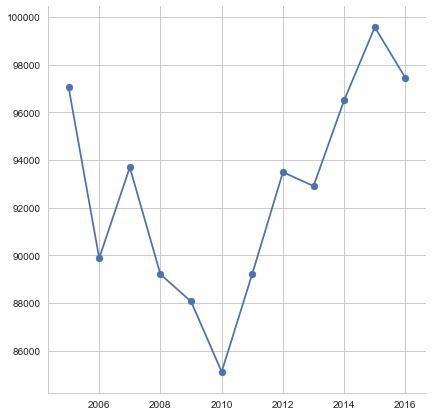

In [12]:

size = sw_df.groupby(['year']).size()
#size.sort_values(ascending=False).head(100)
plt.plot(size.index.values, size.values)
plt.scatter(size.index.values, size.values, marker='o')
plt.show()

Total amount of starts in every age group. Trend is increasing but its not a big different.

### b) including differen group ages

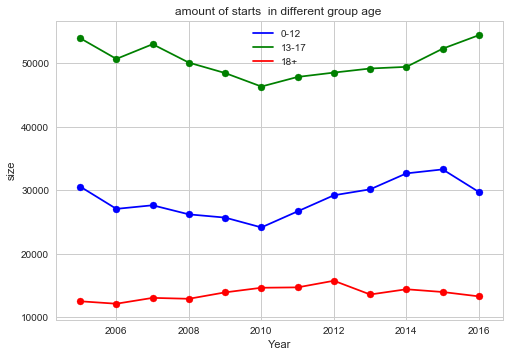

In [13]:
fig, ax = plt.subplots()
amount = sw_df.groupby(['year', 'group_age']).size()
#print(amount)
ax.scatter(amount.index.levels[0].values, amount.xs('0-12', level='group_age').values, c='b', label='')
ax.plot(amount.index.levels[0].values, amount.xs('0-12', level='group_age').values, c='b',label='0-12')
ax.scatter(amount.index.levels[0].values, amount.xs('13-17', level='group_age').values, c='g', label='')
ax.plot(amount.index.levels[0].values, amount.xs('13-17', level='group_age').values, c='g',label='13-17')
ax.scatter(amount.index.levels[0].values, amount.xs('18+', level='group_age').values, c='r', label='')
ax.plot(amount.index.levels[0].values, amount.xs('18+', level='group_age').values, c='r',label='18+')
plt.title('amount of starts  in different group age ')
plt.xlabel('Year')
plt.ylabel('size')
plt.legend()
plt.show()


### c) club through years

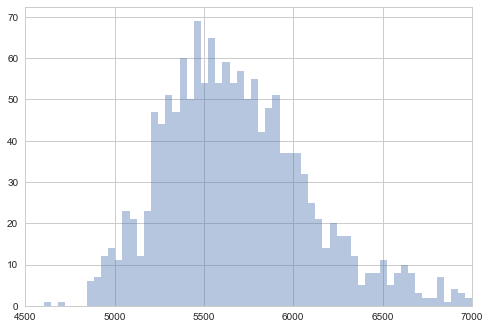

In [14]:
one_gren = sw_df[(sw_df['year']==2008) & (sw_df['group_age']=='18+')& (sw_df['gren']=='100m Frisim')].milisec_time
fig, ax = plt.subplots()
sns.distplot(one_gren.values, kde=False, bins=100)
ax.set_xlim([4500, 7000])
plt.show()

In [15]:
var = 'Helsingborgs Simsällskap'
club_starts = sw_df[sw_df['club']==var]
club_starts_year = club_starts.groupby('year').size()

In [16]:
print(club_starts_year.head(20))

year
2005    3319
2006    3047
2007    3269
2008    3128
2009    3254
2010    2860
2011    2626
2012    2303
2013    2369
2014    2641
2015    2859
2016    3406
dtype: int64


In [17]:
var = 'Helsingborgs Simsällskap'
unique = sw_df[sw_df['club']==var].drop_duplicates(subset=['name', 'year'])
#print(unique)
temp = unique.groupby(['year', 'group_age']).size()
temp = temp.reset_index()
temp.head()


,year,group_age,0
0,2005,0-12,45
1,2005,13-17,43
2,2005,18+,12
3,2006,0-12,56
4,2006,13-17,46


Creating data for four club comparison.

In [18]:
var_list =['Helsingborgs Simsällskap','Linköpings Allmänna SS','Jönköpings Simsällskap','Upsala Simsällskap ']

unique = sw_df.drop_duplicates(subset=['name', 'year'])
temp = unique.groupby(['club','year', 'group_age']).size()
temp = temp.reset_index()
temp.columns = list(['club', 'year', 'group_age', 'amount'])

In [22]:
temp.head()

,club,year,group_age,amount
0,Alingsås SLS,2005,0-12,4
1,Alingsås SLS,2005,13-17,17
2,Alingsås SLS,2006,13-17,17
3,Alingsås SLS,2006,18+,3
4,Alingsås SLS,2007,0-12,8


In [19]:
sns.set(style="whitegrid")
g = sns.factorplot(x='year',y=0, hue='group_age', data=temp, hue_order=['0-12', '13-17', '18+'] ,
                   size=6, kind="bar", palette="muted")
g.set(xlabel='Year', ylabel='Number of swimmers')
#g.fig.legend(labels=['Under 11', '12-15', 'Over 16'] )
g.despine(left=True)
plt.show()

C:\Users\woj\Anaconda3\lib\site-packages\seaborn\categorical.py:1468: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1 but corresponding boolean dimension is 497
  stat_data = remove_na(group_data[hue_mask])


IndexError: index 2 is out of bounds for axis 1 with size 1

In [20]:
var_list =['Helsingborgs Simsällskap','Linköpings Allmänna SS','Jönköpings Simsällskap','Upsala Simsällskap']
temp2016=temp[temp['year']==2016]
temp2016 = temp2016[temp2016.club.isin(var_list)]
temp2016.head()
g=sns.FacetGrid(temp2016, col='club',size=3)
g.map(sns.barplot, 'group_age', 0, palette="muted")
plt.show()

KeyError: '[0] not in index'

In [ ]:
var_list =['Malmö Kappsimningsklubb', 'Simklubben Poseidon', 'Täby Sim', 'Simklubben Neptun']
temp2016=temp[temp['year']==2016]
temp2016 = temp2016[temp2016.club.isin(var_list)]
temp2016.head()
g=sns.FacetGrid(temp2016, col='club',size=3)
g.map(sns.barplot, 'group_age', 0, palette="muted")
plt.show()

Lets do scater plot for diferent age

In [ ]:
var ='Helsingborgs Simsällskap'
one_club = temp[temp['club']==var]

sns.regplot(x=one_club[one_club['group_age']=='0-12'].year, y=one_club[one_club['group_age']=='0-12'].amount, color='red',fit_reg=False)
sns.regplot(x=one_club[one_club['group_age']=='13-17'].year, y=one_club[one_club['group_age']=='13-17'].amount, color='green',fit_reg=False)
sns.regplot(x=one_club[one_club['group_age']=='18+'].year, y=one_club[one_club['group_age']=='18+'].amount, fit_reg=False)
plt.show()

In [ ]:
var ='Helsingborgs Simsällskap'
one_club = temp[temp['club']==var]
fig, ax = plt.subplots()
ax.scatter(one_club[one_club['group_age']=='0-12'].year, one_club[one_club['group_age']=='0-12'].amount, c='b', label='')
ax.plot(one_club[one_club['group_age']=='0-12'].year, one_club[one_club['group_age']=='0-12'].amount, c='b', label='0-12')
ax.scatter(one_club[one_club['group_age']=='13-17'].year, one_club[one_club['group_age']=='13-17'].amount, c='g', label='')
ax.plot(one_club[one_club['group_age']=='13-17'].year, one_club[one_club['group_age']=='13-17'].amount, c='g',label='13-17')
ax.scatter(one_club[one_club['group_age']=='18+'].year,one_club[one_club['group_age']=='18+'].amount, c='r', label='')
ax.plot(one_club[one_club['group_age']=='18+'].year,one_club[one_club['group_age']=='18+'].amount, c='r',label='18+')
plt.title('Amount of swimers in different group in '+ var)
plt.xlabel('Year')
plt.ylabel('Amount')
plt.legend()
plt.show()

In [ ]:
tid = timedelta(minutes=1, seconds=20, milliseconds=11)
#print(tid)
my_tid=sw_df.loc[0,'time']
print(str_to_time(my_tid))
df.time.apply()

In [ ]:
sw_df['time_edit'] = sw_df['time'].apply(lambda x: str_to_time(x))
sw_df.time_edit.info

In [ ]:
zero = timedelta(minutes=1, seconds=23, milliseconds=1)
zero.microseconds

In [ ]:
df.Finapoäng.sort_values(ascending=False).head(10)

In [ ]:
sw_df.groupby(['year', 'competition name']).size().sort_values(ascending=False)

In [ ]:
type(blabla)